<span style="color:#d2b4de; font-size:25px; font-weight:bold">Digit detection and location with YOLO</span>

In [ ]:
from ultralytics import YOLO
MODEL_PATH = r"/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/runs/detect/train12/weights/best.pt"
model = YOLO(MODEL_PATH) 


# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

metrics = metrics.box


In [5]:
# Print pretty performance summary 💖
print(f"Precision (mean): {metrics.mp:.4f}")
print(f"Recall (mean): {metrics.mr:.4f}")
print(f"mAP@0.5: {metrics.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.map:.4f}")

Precision (mean): 0.9624
Recall (mean): 0.9835
mAP@0.5: 0.9947
mAP@0.5:0.95: 0.9299


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt") # Load a COCO-pretrained YOLO11n model

In [2]:
import torch

if torch.cuda.is_available():

    device_index = 0
    device_name = torch.cuda.get_device_name(device_index)
    print(f"Device: cuda:{device_index}, Name: {device_name}")   
else:
    print("Using CPU")

device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

model.to(device)

Device: cuda:0, Name: NVIDIA GeForce RTX 3090
cuda:0


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

<span style="color:#d2b4de; font-size:18px; font-weight:bold">Inference before training</span>


0: 480x640 1 chair, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


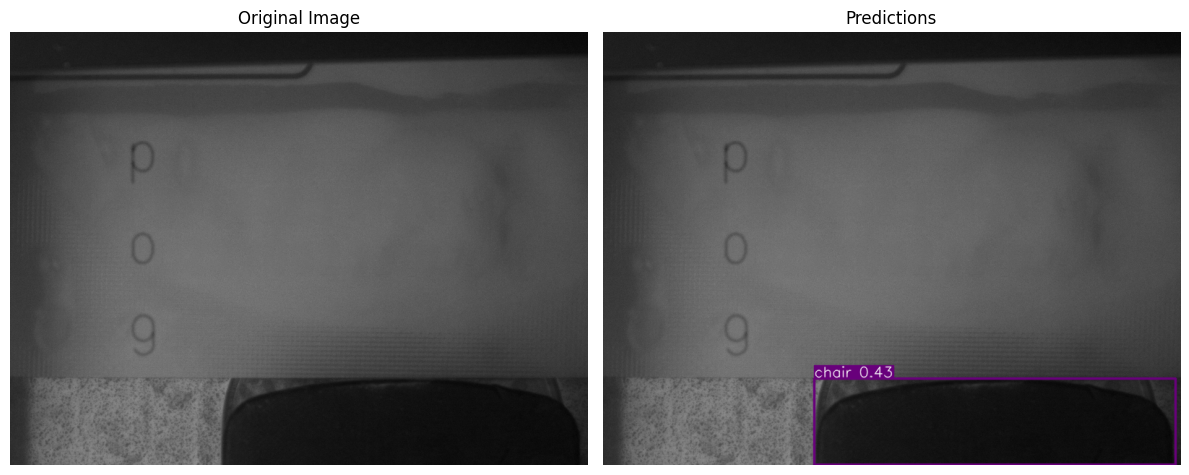

In [6]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

img_path = r"/mnt/DADES/home/jgarcia/lamquid/data/synthetic/simulated/SS000005.png"

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model = YOLO("yolo11n.pt")
results = model.predict(source=image, imgsz=640)

annotated_image = results[0].plot() 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(annotated_image)
ax[1].set_title("Predictions")
ax[1].axis("off")

plt.tight_layout()
plt.show()

<span style="color:#d2b4de; font-size:18px; font-weight:bold">Preprare data - COCO format</span>

In [7]:
# SPLIT DATA

import os
import shutil
from sklearn.model_selection import train_test_split

data_path = "/mnt/DADES/home/jgarcia/lamquid/data/synthetic/simulated/"

image_files = [f for f in os.listdir(data_path) if f.endswith(('.jpg', '.png', '.bmp'))]
number_of_samples = len(image_files)
print("Number of samples: ", number_of_samples)

# Create directories
current_path = os.getcwd()
dataset_dir = os.path.join(current_path, "dataset_real_plus_synthetic")

Number of samples:  462


In [8]:
os.makedirs(os.path.join(dataset_dir, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "labels/val"), exist_ok=True)

train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42) # Split

for file_name in train_files:
    shutil.copy(os.path.join(data_path, file_name), os.path.join(dataset_dir, "images/train", file_name))

for file_name in val_files:
    shutil.copy(os.path.join(data_path, file_name), os.path.join(dataset_dir, "images/val", file_name))

print(f"Train samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

print("Dataset split and copied successfully!")

Train samples: 369
Validation samples: 93
Dataset split and copied successfully!


In [22]:
import os
import shutil

source_folder = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset/images/val"
destination_folder = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_real_plus_synthetic/images/val"

# 💖 List of allowed image extensions
image_extensions = [ '.bmp']

# ✨ Copy images
for filename in os.listdir(source_folder):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        src_path = os.path.join(source_folder, filename)
        dst_path = os.path.join(destination_folder, filename)
        shutil.copy2(src_path, dst_path)

print("✨ All images copied successfully! 🎀")


✨ All images copied successfully! 🎀


In [20]:
# READ ANNOTATIONS

import os
import json

directory_path = "/mnt/DADES/home/jgarcia/CODE/0) DATA GENERATION/"

def inspect_dataset_json(directory_path, json_filename="STELA_DATASET.json"):
    """
    Inspect the JSON file in the dataset directory and print its contents.

    Args:
        directory_path (str): Path to the dataset directory.
        json_filename (str): Name of the JSON file to inspect.
    """
    json_path = os.path.join(directory_path, json_filename)

    # Check if the JSON file exists
    if not os.path.exists(json_path):
        print(f"JSON file {json_filename} does not exist in the directory {directory_path}.")
        return

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        print("Data correctly loaded.")
        return data
        
    except Exception as e:
        print(f"Error reading JSON file {json_filename}: {e}")
        return None
        
# Load JSON data
data = inspect_dataset_json(directory_path)

Data correctly loaded.


In [9]:
if data:
    classes = []

    # Extract unique classes
    for i in data:
        entry = data[i]
        for element in entry["chars"]:
            classes.append(str(element[0]))

    # Sort and include "Region"
    classes = sorted(list(set(classes)))
    #classes.append("Region")
    print("Classes in dataset:", classes)

    # Create class-to-id and id-to-class mappings
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}
    id_to_class = {idx: cls for cls, idx in class_to_id.items()}

    print("Class-to-ID Mapping:", class_to_id)
    print("ID-to-Class Mapping:", id_to_class)


Data correctly loaded.
Classes in dataset: [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '¡', '¢', '£', '¤', '¥', '§', '©', 'ª', '\xad', '®', '°', '±', 'µ', 'º', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ']
Class-to-ID Mapping: {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7

In [23]:
# CREATE LABELS
import json

image_width = 800
image_height = 600

for filename in  os.listdir(os.path.join(dataset_dir, "images/train")):

    sample_info = ""
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        
        if filename.endswith(('.bmp')):
            json_filename = filename.replace("__","\\\\")
        else:
            json_filename = filename
   
        for entry in data.values():
            
            if entry["file"] == json_filename:

                scale = float(entry["scale"])

                for char in entry["chars"]:

                    char_label = str(class_to_id[str(char[0])])
                    center_x, center_y = char[1:]
                    
                    height = 100*scale
                    width = 60*scale
                    
                    left = center_x 
                    right = center_x + width // 2
                    top = center_y - height // 2
                    bottom = center_y 

                    w = (right - left) / image_width
                    h = (bottom - top) / image_height

                    # w = right-left
                    # h = bottom-top
                    
                    # x = left + w/2
                    # y = top + h/2

                    x = (left + (w * image_width) / 2) / image_width
                    y = (top + (h * image_height) / 2) / image_height

                    
                    sample_info += f"{char_label} {x} {y} {w} {h}\n"

                # sample_info += str(class_to_id["Region"]) Region info
                
        label_path = os.path.join(dataset_dir, "labels/train", f"{os.path.splitext(filename)[0]}.txt")
        
        os.makedirs(os.path.dirname(label_path), exist_ok=True)

        with open(label_path, "w") as label_file:
            label_file.write(sample_info)

In [24]:
# CREATE LABELS

for filename in  os.listdir(os.path.join(dataset_dir, "images/val")):

    sample_info = ""
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        

        if filename.endswith(('.bmp')):
            json_filename = filename.replace("__","\\\\")
        else:
            json_filename = filename
   
        for entry in data.values():
            
            if entry["file"] == json_filename:

                scale = float(entry["scale"])

                for char in entry["chars"]:

                    char_label = str(class_to_id[str(char[0])])
                    center_x, center_y = char[1:]
                    
                    height = 100*scale
                    width = 60*scale
                    
                    left = center_x 
                    right = center_x + width // 2
                    top = center_y - height // 2
                    bottom = center_y 
                    
                    w = (right - left) / image_width
                    h = (bottom - top) / image_height

                    # w = right-left
                    # h = bottom-top
                    
                    # x = left + w/2
                    # y = top + h/2

                    x = (left + (w * image_width) / 2) / image_width
                    y = (top + (h * image_height) / 2) / image_height

                    
                    sample_info += f"{char_label} {x} {y} {w} {h}\n"
                    
                    sample_info += f"{char_label} {x} {y} {w} {h}\n"

                # sample_info += str(class_to_id["Region"]) Region info
                
        label_path = os.path.join(dataset_dir, "labels/val", f"{os.path.splitext(filename)[0]}.txt")
        
        os.makedirs(os.path.dirname(label_path), exist_ok=True)

        with open(label_path, "w") as label_file:
            label_file.write(sample_info)

In [19]:
import os
import json
import yaml

train_path =  os.path.join(dataset_dir, "labels/train")
val_path =  os.path.join(dataset_dir, "labels/val")
yaml_output_path = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_real_plus_synthetic/data.yaml"

yaml_content = {
        "train": train_path,
        "val": val_path,
        "names": {idx: cls for cls, idx in class_to_id.items()}
    }

   
with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(yaml_content, yaml_file, sort_keys=False)

<span style="color:#d2b4de; font-size:18px; font-weight:bold">Training the model</span>

In [ ]:
results = model.train(data="dataset/data.yaml", epochs=500, imgsz=640, patience=50, plots=True, multi_scale=True)

![Training Results](runs/detect/train3/results.png)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Paths
#IMG_PATH = r"/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset/images/val/NG_02_20220927__19700224_181655819_.bmp"
IMG_PATH = r"/mnt/DADES/home/jgarcia/CODE/1) DATA AUGMENTATION/Generated Images/AI_Gen_Image_11.png"
MODEL_PATH = r"/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/runs/detect/train3/weights/best.pt"

# Load image and convert to RGB
image = cv2.imread(IMG_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load YOLO model
model = YOLO(MODEL_PATH)

# Run detection
results = model.predict(source=image, conf=0.8, imgsz=640)  # Confidence threshold from F1 curve
class_names = model.names

# Annotated image
annotated_image = image_rgb.copy()
detected_text = []

heights = []
widths = []

# Extract bounding boxes and class names
for result in results:
    for box in result.boxes:
        cls = int(box.cls.item())
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_name = class_names[cls]

        # Adjust text placement
        text_x, text_y = x1, max(y1 - 5, 10)

        width = x2 - x1
        height = y2 - y1

        heights.append(height)
        widths.append(width)

        # Draw text on the image
        cv2.putText(
            annotated_image, class_name, (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, cv2.LINE_AA
        )

        detected_text.append([class_name, text_x, text_y])

# Sort detected characters by Y (top to bottom), then by X (left to right)
detected_text.sort(key=lambda item: (item[2], item[1]))

avg_height = np.mean(heights)
avg_width = np.mean(widths)

line_threshold = avg_height
spacing_threshold = 50/32 * avg_width

lines, current_line = [], []

for i, char in enumerate(detected_text):
    if i == 0 or abs(char[2] - detected_text[i - 1][2]) <= line_threshold:
        current_line.append(char)
    else:
        lines.append(current_line)
        current_line = [char]
lines.append(current_line)

# Sort each line by X-coordinate and format text
decoded_lines = []
for line in lines:
    sorted_line = sorted(line, key=lambda c: c[1])
    line_str = "".join(
        (f" {c[0]}" if j > 0 and (c[1] - sorted_line[j - 1][1]) > spacing_threshold else c[0])
        for j, c in enumerate(sorted_line)
    )
    decoded_lines.append(line_str)

# Print extracted text
print("Extracted text:\n", "\n ".join(decoded_lines))

# Display images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(annotated_image)
ax[1].set_title("Predictions")
ax[1].axis("off")

plt.tight_layout()
plt.show()


### Problem Statement
We are facing **two main issues** in our dataset:

1. **Unbalanced Dataset** – Some classes appear significantly more frequently than others.  
   *Visualization:*  
   ![Class Distribution](runs/detect/train3/labels.jpg)


2. **Missing Characters** – Certain characters are completely absent from the dataset, making it difficult for the model to generalize well.

---

### Solution Approach
To **address these issues**, we will **use a fine-tuned generative model** to create synthetic samples of **underrepresented characters**, ensuring better class balance and improving overall model performance. 🚀  

This strategy will help:
✅ **Balance the dataset** by generating more samples for rare characters.  
✅ **Improve model generalization** to correctly recognize all character classes.  


<span style="color:#d2b4de; font-size:18px; font-weight:bold">Experiment: Test with unseen digits </span>


In [ ]:
# Generate an image containing an unseen character

from diffusers import StableDiffusionInpaintPipeline
from transformers import CLIPTextModel
import torch

if torch.cuda.is_available():

    device_index = 0
    device_name = torch.cuda.get_device_name(device_index)
    print(f"Device: cuda:{device_index}, Name: {device_name}")   
else:
    print("Using CPU")

device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Inpainting model 
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    r"/mnt/DADES/home/jgarcia/CODE/1) DATA AUGMENTATION/Models/stable-diffusion-inpainting-custom-masks-and-prompt-2",
    torch_dtype=torch.float16,
)

pipe.to(device)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from diffusers import StableDiffusionInpaintPipeline
import torch

# Ensure you're using an interactive backend
%matplotlib widget

# Load the image
img_path = "/mnt/DADES/home/jgarcia/CODE/dataset/images/NG__19700227_154848392_.bmp"
image = Image.open(img_path)
image_np = np.array(image)

# Prepare a single-channel mask (same dimensions as the image)
mask = np.zeros_like(image_np, dtype=np.uint8)

# Variables to store rectangle coordinates
start_point = None
end_point = None

# Callback function for mouse click and release
def on_click(event):
    global start_point
    if event.inaxes:
        start_point = (int(event.xdata), int(event.ydata))
        print(f"Start point: {start_point}")

def on_release(event):
    global start_point, end_point, mask
    if event.inaxes and start_point:
        end_point = (int(event.xdata), int(event.ydata))
        print(f"End point: {end_point}")

        # Draw the rectangle on the mask
        x1, y1 = start_point
        x2, y2 = end_point
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)

        mask[y_min:y_max, x_min:x_max] = 255  # Fill mask with white

        # Draw the rectangle on the plot
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='red', facecolor='none')
        event.inaxes.add_patch(rect)
        plt.draw()

# Function to run the pipeline with the selected mask
# Function to save the mask as an image
def save_mask(_):
    global mask

    # Save the mask as an image
    mask_image_path = "mask.png"
    mask_image = Image.fromarray(mask)  # Convert the NumPy array to a PIL image
    mask_image.save(mask_image_path)

# Display the image with click-and-drag functionality
fig, ax = plt.subplots()
ax.imshow(image_np, cmap='gray')
ax.set_title("Click and drag to mask a rectangle")
ax.axis("off")

# Connect the events
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('button_release_event', on_release)

# Add a button to run the pipeline
button = widgets.Button(description="Create Mask")
button.on_click(save_mask)
display(button)

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from PIL import Image
import torch

%matplotlib inline

value = "S" # Value to generate
num_samples = 1  # Number of images to generate

prompt = f"Generate the value [[{value}]]."
generator = torch.Generator(device).manual_seed(0) 

mask_path = "mask.png"

image = Image.open(img_path).convert("RGB") 
mask = Image.open(mask_path).convert("L")    

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask,
    guidance_scale=15,
    generator=generator,
    num_images_per_prompt=num_samples,
    num_inference_steps=70 # number of denoising steps
).images


plt.imshow(images[0])
plt.axis("off")
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Paths
MODEL_PATH = r"/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/runs/detect/train3/weights/best.pt"

image_np = np.array(images[0])
image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) 

model = YOLO(MODEL_PATH)

results = model.predict(source=image_rgb, conf=0.8, imgsz=640)  # Confidence threshold from F1 curve (conf)
class_names = model.names

annotated_image = image_rgb.copy()
detected_text = []

heights = []
widths = []

for result in results:
    for box in result.boxes:
        cls = int(box.cls.item())
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_name = class_names[cls]

        text_x, text_y = x1, max(y1 - 5, 10)

        width = x2 - x1
        height = y2 - y1

        heights.append(height)
        widths.append(width)

        cv2.putText(
            annotated_image, class_name, (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, cv2.LINE_AA
        )

        detected_text.append([class_name, text_x, text_y])

# Sort detected characters by Y (top to bottom), then by X (left to right)
detected_text.sort(key=lambda item: (item[2], item[1]))

avg_height = np.mean(heights)
avg_width = np.mean(widths)

line_threshold = avg_height
spacing_threshold = 50/32 * avg_width

lines, current_line = [], []

for i, char in enumerate(detected_text):
    if i == 0 or abs(char[2] - detected_text[i - 1][2]) <= line_threshold:
        current_line.append(char)
    else:
        lines.append(current_line)
        current_line = [char]
lines.append(current_line)

# Sort each line by X-coordinate and format text
decoded_lines = []
for line in lines:
    sorted_line = sorted(line, key=lambda c: c[1])
    line_str = "".join(
        (f" {c[0]}" if j > 0 and (c[1] - sorted_line[j - 1][1]) > spacing_threshold else c[0])
        for j, c in enumerate(sorted_line)
    )
    decoded_lines.append(line_str)
    
print("Extracted text:\n", "\n ".join(decoded_lines))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(annotated_image)
ax[1].set_title("Predictions")
ax[1].axis("off")

plt.tight_layout()
plt.show()

**Note:** The model successfully identified the unseen digit's location. However, its classification is incorrect since the digit does not belong to any of the trained classes.

In [ ]:
import string
import matplotlib.pyplot as plt

current_chars = ['/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', 'E', 'H', 'L', 'O', 'P', 'R', 'X']
all_chars = list(string.ascii_uppercase + string.ascii_lowercase + string.digits + string.punctuation)

missing_chars = list(set(all_chars) - set(current_chars))

print(missing_chars)
print(len(missing_chars))

**ASK!!** Should we consider all the characters? Differenciate upper vs lower cases?? 

<span style="color:#d2b4de; font-size:18px; font-weight:bold">Training using synthetic data</span>

In [1]:
import os
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Define paths
synthetic_data_path = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2"

real_data_path_train = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset/images/train"
real_data_path_test = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset/images/val"

# Get real images
r_image_files_train = [f for f in os.listdir(real_data_path_train) if f.endswith(('.jpg', '.png', '.bmp'))]
number_of_r_samples_train = len(r_image_files_train)
print("Number of real samples for training: ", number_of_r_samples_train)

r_image_files_test = [f for f in os.listdir(real_data_path_test) if f.endswith(('.jpg', '.png', '.bmp'))]
number_of_r_samples_test = len(r_image_files_test)
print("Number of real samples for training: ", number_of_r_samples_test)

# Get synthetic images and extract character types
s_image_files = [f for f in os.listdir(synthetic_data_path) if f.endswith(('.jpg', '.png', '.bmp'))]

number_of_s_samples = len(s_image_files)
print("Number of synthetic samples: ", number_of_s_samples)

# Create directories
current_path = os.getcwd()
dataset_dir = os.path.join(current_path, "dataset_sdxl")
os.makedirs(os.path.join(dataset_dir, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "labels/val"), exist_ok=True)

# Move real images
for file in r_image_files_train:
    shutil.copy(os.path.join(real_data_path_train, file), os.path.join(dataset_dir, "images/train", file))

for file in r_image_files_test:
    shutil.copy(os.path.join(real_data_path_test, file), os.path.join(dataset_dir, "images/val", file))

# Split synthetic images into train and validation sets
train_synthetic, val_synthetic = train_test_split(s_image_files, test_size=0.05, random_state=42)

# Move synthetic images
for file in train_synthetic:
    shutil.copy(os.path.join(synthetic_data_path, file), os.path.join(dataset_dir, "images/train", file))

for file in val_synthetic:
    shutil.copy(os.path.join(synthetic_data_path, file), os.path.join(dataset_dir, "images/val", file))

# Final output
print("\n")
print(f"Real Train samples: {number_of_r_samples_train}")
print(f"Real Validation samples: {number_of_r_samples_test}")
print(f"Synthetic Train samples: {len(train_synthetic)}")
print(f"Synthetic Validation samples: {len(val_synthetic)}")

print("Dataset split and copied successfully! 🎉💖")

Number of real samples for training:  580
Number of real samples for training:  146
Number of synthetic samples:  3000


Real Train samples: 580
Real Validation samples: 146
Synthetic Train samples: 2850
Synthetic Validation samples: 150
Dataset split and copied successfully! 🎉💖


In [2]:
import os
import json

# Define paths
directory_path = "/mnt/DADES2/STELA/data"
synthetic_directory_path = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2/generated_data.json"

def load_json_data(json_path):
    """
    Load and return data from a JSON file.

    Args:
        json_path (str): Path to the JSON file.

    Returns:
        dict: JSON data as a dictionary, or None if loading fails.
    """
    if not os.path.exists(json_path):
        print(f"JSON file not found: {json_path}")
        return None

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {json_path}")
        return data
    except Exception as e:
        print(f"Error reading {json_path}: {e}")
        return None

# Load real and synthetic dataset JSONs
real_data = load_json_data(os.path.join(directory_path, "STELA_DATASET.json"))
synthetic_data = load_json_data(synthetic_directory_path)

# Extract unique classes
classes = set()

# Process real dataset
if real_data:
    for key, entry in real_data.items():
        for element in entry.get("chars", []):
            classes.add(str(element[0]))

# Process synthetic dataset
if synthetic_data:
    for key, entry in synthetic_data.items():
        for element in entry.get("chars", []):
            classes.add(str(element[0]))

# Sort classes and finalize
classes = sorted(classes)  # Sort for consistency

# add marking_region class
classes.append("Marking_Region")

# Create mappings
class_to_id = {cls: idx for idx, cls in enumerate(classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

# Output results
print("Final Classes:", classes)
print("Class-to-ID Mapping:", class_to_id)
print("ID-to-Class Mapping:", id_to_class)


Successfully loaded /mnt/DADES2/STELA/data/STELA_DATASET.json
Successfully loaded /mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2/generated_data.json
Final Classes: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '¡', '¢', '£', '¤', '¥', '§', '©', 'ª', '\xad', '®', '°', '±', 'µ', 'º', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ',

In [3]:
from NewPal import getCodeWidth

VERSION=2

NewPal,50



In [7]:
import os
import json

# Define paths
directory_path = "/mnt/DADES/home/jgarcia/CODE/0) DATA GENERATION/STELA_DATASET.json" # "/mnt/DADES2/STELA/data"
synthetic_directory_path = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2/generated_data.json"

# Load JSON data
real_data = load_json_data(directory_path)# os.path.join(directory_path, "STELA_DATASET.json"))
synthetic_data = load_json_data(synthetic_directory_path)

# Image dimensions
image_width = 800
image_height = 600

# Function to get the width of a character (placeholder for missing function)
def getCodeWidth(char_label):
    """Placeholder function for calculating character width."""
    return 10  # Adjust as needed based on dataset

# Missing values placeholder
missing_values_fav = set()  # Define missing values list if needed

count = 0
# Generate labels for train and val sets
for split in ["train", "val"]:

    image_dir = os.path.join(dataset_dir, f"images/{split}")
    label_dir = os.path.join(dataset_dir, f"labels/{split}")

    os.makedirs(label_dir, exist_ok=True)

    for filename in os.listdir(image_dir):

        sample_info = ""
        found = False

        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            
            if "processed" not in filename: 

                json_filename = filename 
            
                # Find matching entry in JSON data
                for entry in real_data.values():
                    
                    if entry["file"].replace("\\","_")  == json_filename:
                        
                        found = True
                        
                        scale = float(entry["scale"])
    
            
                        for char in entry["chars"]:
                            
                            
                            char_label = str(class_to_id[str(char[0])])
    
                            center_x, center_y = char[1:]
    
                            height = 100 * scale
                            width = 60 * scale
    
                            if char_label in missing_values_fav:
                                if getCodeWidth(char_label) >= 20:
                                    print(f"⚠️ Warning: Unexpected width for character {char_label}")
                                    center_x -= 8
    
                            left = center_x - 5
    
                            character = char[0]
                            if len(str(character)) > 1:
                                character = character[:-1]
    
                            right = center_x + width // 10 + getCodeWidth(str(character)) * scale
                            top = center_y - height // 2
                            bottom = center_y
    
                            w = (right - left) / image_width
                            h = (bottom - top) / image_height
    
                            x = (left + (w * image_width) / 2) / image_width
                            y = (top + (h * image_height) / 2) / image_height
    
                            sample_info += f"{char_label} {x} {y} {w} {h}\n"

                        # add marking region

                        points = entry["reserve"]
                        x_coords = [point[1] for point in points]
                        y_coords = [point[2] for point in points]

                        left = min(x_coords)
                        right = max(x_coords)
                        top = min(y_coords)
                        bottom = max(y_coords)

                        # YOLO format: center_x, center_y, width, height (all normalized)
                        x = (left + right) / 2 / image_width
                        y = (top + bottom) / 2 / image_height
                        w = (right - left) / image_width
                        h = (bottom - top) / image_height

                        marking_label = str(class_to_id["Marking_Region"])
                        sample_info += f"{marking_label} {x} {y} {w} {h}\n"

                if not found: 
                    count += 1
                
                else:
                    
                    label_path = os.path.join(label_dir, f"{os.path.splitext(filename)[0]}.txt")
                    with open(label_path, "w") as label_file:
                        label_file.write(sample_info)
                    


print(count)

Successfully loaded /mnt/DADES/home/jgarcia/CODE/0) DATA GENERATION/STELA_DATASET.json
Successfully loaded /mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2/generated_data.json
3000


In [6]:
count = 0
# Generate labels for train and val sets
for split in ["train", "val"]:

    image_dir = os.path.join(dataset_dir, f"images/{split}")
    label_dir = os.path.join(dataset_dir, f"labels/{split}")
    os.makedirs(label_dir, exist_ok=True)

    for filename in os.listdir(image_dir):
        sample_info = ""
        found = False
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            
            if "processed" not in filename: 
                json_filename = filename 
                
                # Find matching entry in JSON data
                for entry in synthetic_data.values():

                                   
                    if entry["file_name"] == json_filename:
                        
                        found = True
                        
                        scale = float(entry["scale"])
    
            
                        for char in entry["chars"]:
    
                            
                            char_label = str(class_to_id[str(char[0])])
    
                            center_x, center_y = char[1:]
    
                            height = 100 * scale
                            width = 60 * scale
    
                            if char_label in missing_values_fav:
                                if getCodeWidth(char_label) >= 20:
                                    print(f"⚠️ Warning: Unexpected width for character {char_label}")
                                    center_x -= 8
    
                            left = center_x - 5
    
                            character = char[0]
                            if len(str(character)) > 1:
                                character = character[:-1]
    
                            right = center_x + width // 10 + getCodeWidth(str(character)) * scale
                            top = center_y - height // 2
                            bottom = center_y
    
                            w = (right - left) / image_width
                            h = (bottom - top) / image_height
    
                            x = (left + (w * image_width) / 2) / image_width
                            y = (top + (h * image_height) / 2) / image_height
    
                            sample_info += f"{char_label} {x} {y} {w} {h}\n"

                        # add marking region
                        
                        points = entry["reverse"]
                        x_coords = [point[1] for point in points]
                        y_coords = [point[2] for point in points]

                        left = min(x_coords)
                        right = max(x_coords)
                        top = min(y_coords)
                        bottom = max(y_coords)

                        # YOLO format: center_x, center_y, width, height (all normalized)
                        x = (left + right) / 2 / image_width
                        y = (top + bottom) / 2 / image_height
                        w = (right - left) / image_width
                        h = (bottom - top) / image_height

                        marking_label = str(class_to_id["Marking_Region"])
                        sample_info += f"{marking_label} {x} {y} {w} {h}\n"
       
                if not found: 
                    count += 1

                else:
                    
                    # Save label file
                    label_path = os.path.join(label_dir, f"{os.path.splitext(filename)[0]}.txt")
                    with open(label_path, "w") as label_file:
                        label_file.write(sample_info)

print(count)

726


In [8]:
import os

# Define output directories
output_train = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/labels/train"
output_test = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/labels/val"

# Function to check for empty .txt files
def check_empty_files(directory):
    """Checks for empty .txt files in the given directory."""
    if not os.path.exists(directory):
        print(f"🚨 Directory not found: {directory}")
        return 0

    empty_files = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_name.endswith(".txt") and os.path.isfile(file_path) and os.path.getsize(file_path) == 0:
            empty_files.append(file_name)

    # Print results
    if empty_files:
        print(f"⚠️ Found {len(empty_files)} empty files in {directory}:")
        for file in empty_files:
            print(f"   - {file}")
    else:
        print(f"✅ No empty files found in {directory}!")

    return len(empty_files)

# Check train and test label directories
empty_train = check_empty_files(output_train)
empty_test = check_empty_files(output_test)

# Summary
total_empty = empty_train + empty_test
if total_empty > 0:
    print(f"🚨 Total empty files found: {total_empty}")
else:
    print("🎉 All label files have content!")

✅ No empty files found in /mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/labels/train!
✅ No empty files found in /mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/labels/val!
🎉 All label files have content!


In [9]:
# yaml creation

import yaml

# Paths to dataset
dataset_yaml_path = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/dataset.yaml"

train_path = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/images/train"
val_path = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/images/val"


# YAML dictionary structure
dataset_yaml = {
    "train": train_path,
    "val": val_path,
    "names": id_to_class  # Assign the dictionary to 'names'
}

# Save to YAML file
with open(dataset_yaml_path, "w") as yaml_file:
    yaml.dump(dataset_yaml, yaml_file, default_flow_style=False, allow_unicode=True)

In [ ]:
results = model.train(data="syn_dataset/dataset.yaml", epochs=2, imgsz=640, patience=50, plots=True, multi_scale=True)

# Plot Results

In [70]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from NewPal import getCodeWidth
import json

# Paths
MODEL_PATH = r"/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/runs/detect/train12/weights/best.pt"
model = YOLO(MODEL_PATH)

# DIRECTORIES

RealImagesDir = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2"
RealImagesJsonDir = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2/generated_data.json"

try:
    with open(RealImagesJsonDir, "r") as f: 
        Annotations = json.load(f)
        i = len(Annotations)
        print("JSON file loaded successfully.")
        print(f"Number of entries: {i}")

except FileNotFoundError:
    print("JSON file not found.")

JSON file loaded successfully.
Number of entries: 3000


In [59]:
import random
random_entries = random.sample(list(Annotations.items()), 50)

In [24]:
def decode_chars(chars):
    """
    Decodes the chars list into a string by sorting based on y-coordinates (lines) first
    and then x-coordinates within each line.

    Args:
        chars (list): A list of characters with their x and y positions.
                      Each character is represented as a tuple (char, x, y).

    Returns:
        str: The decoded string with line breaks as per the image layout.
    """
    line_threshold = 5  
    spacing_threshold = 48*float(entry["scale"])
    # print("Tresh:", spacing_threshold)
    
    chars = sorted(chars, key=lambda c: c[2])  # Sort by y-coordinate initially

    lines = []
    current_line = []
    for i, char in enumerate(chars):
        if i == 0 or abs(char[2] - chars[i - 1][2]) <= line_threshold:
            current_line.append(char)
        else:
            lines.append(current_line)
            current_line = [char]
            
    lines.append(current_line)

    # Sort each line by x-coordinate 
    decoded_lines = []
    for line in lines:
        sorted_line = sorted(line, key=lambda c: c[1])
        line_str = ""
        for j in range(len(sorted_line)):
            if j > 0 and (sorted_line[j][1] - sorted_line[j - 1][1]) > spacing_threshold:
                #print(sorted_line[j][1] - sorted_line[j - 1][1])
                line_str += " "  # Add tab space if characters are not too close
            line_str += str(sorted_line[j][0])
        decoded_lines.append(line_str)

    return '\n'.join(decoded_lines)

In [77]:
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

counter = {"Valid Case": 0, "Missplaced Case": 0, "Incorrect Case": 0, "SUrface Deffect Case": 0}

for entry in random_entries:

    entry = random_entries[0][1]
    print(entry)
    
    file = entry["file_name"]
    drawing_region = entry['reverse']
    original_scale = entry['scale']
    original_code = entry["chars"]
    original_code = decode_chars(original_code).replace(" ", "").replace("\n", "")
    print("Original code:", original_code)

    image_path = os.path.join(RealImagesDir, *file.split('\\'))

    # Load and convert the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run model prediction
    results = model.predict(source=image_rgb, conf=0.5, imgsz=600)
    class_names = model.names

    annotated_image = image_rgb.copy()
    detected_text = []

    heights = []
    widths = []

    # Convert image to PIL for text drawing
    image_pil = Image.fromarray(annotated_image)
    draw = ImageDraw.Draw(image_pil)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # Make sure this font exists!
    font = ImageFont.truetype(font_path, 20)

    region = None  # Fix: Initialize region before using it!

    for result in results:
        for box in result.boxes:
            cls = int(box.cls.item())
            if class_names[cls] == "Marking_Region":
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                region = [(x1, y1), (x2, y2)]
                draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
                draw.text((x1, y1 - 22), "Marking Region", font=font, fill=(0, 255, 0))
                break  # Optional: Stop after finding one marking region

    scores = []

    if region:  # Only proceed if region was found
        for result in results:
            for box in result.boxes:
                cls = int(box.cls.item())

                score = box.conf.item()
                scores.append(score)

                class_name = class_names[cls]

                if class_name == "Marking_Region":
                    continue

                x1, y1, x2, y2 = map(int, box.xyxy[0])
                text_x, text_y = x1, max(y1 - 5, 10)

                width = x2 - x1
                height = y2 - y1
                heights.append(height)
                widths.append(width)

                draw.text((text_x, text_y - 22), class_name, font=font, fill=(255, 0, 0))

                char_width = getCodeWidth(class_name)
                draw.rectangle([x1, y1 - 2, x2 + char_width - 8, y2 + 2], outline=(255, 0, 0), width=2)

                detected_text.append([class_name, text_x, text_y])

        annotated_image = np.array(image_pil)
        detected_text.sort(key=lambda item: (item[2], item[1]))

        avg_height = np.mean(heights)
        avg_width = np.mean(widths)

        line_threshold = avg_height
        spacing_threshold = 50 / 32 * avg_width

        lines, current_line = [], []

        for i, char in enumerate(detected_text):
            if i == 0 or abs(char[2] - detected_text[i - 1][2]) <= line_threshold:
                current_line.append(char)
            else:
                lines.append(current_line)
                current_line = [char]
        if current_line:
            lines.append(current_line)

        decoded_lines = []
        for line in lines:
            sorted_line = sorted(line, key=lambda c: c[1])
            line_str = "".join(
                (f" {c[0]}" if j > 0 and (c[1] - sorted_line[j - 1][1]) > spacing_threshold else c[0])
                for j, c in enumerate(sorted_line)
            )
            decoded_lines.append(line_str)

        predicted_code = "\n".join(decoded_lines).replace(" ", "").replace("\n", "")

        print("Predicted code:", predicted_code)

        # Fix: Check if characters are within the region for the entire code
        all_inside = all(
            region[0][0] <= char[1] <= region[1][0] and
            region[0][1] <= char[2] <= region[1][1]
            for char in detected_text
        )

        if predicted_code == original_code:
            if all_inside:
                counter["Valid Case"] += 1
            else:
                counter["Missplaced Case"] += 1
        if predicted_code != original_code:
            if scores.mean() > 0.8:
                counter["Incorrect Case"] += 1
            else:
                counter["SUrface Deffect Case"] += 1
                
print("Final count:", counter)

{'chars': [['S', 287, 287], ['f', 350, 287], ['e', 398, 287], ['z', 452, 287], ['ß', 506, 287], ['8', 562, 287], ['÷', 287, 407], ['f', 341, 407], ['6', 388, 407], ['G', 444, 407], ['r', 508, 407], ['X', 555, 407]], 'code': 'Sfezß8\n÷f6GrX', 'scale': 1.6326059338978363, 'file_name': 'Image_0714_gen_00.png', 'reverse': [['P0', 110, 164], ['P1', 733, 166], ['P2', 733, 410], ['P3', 112, 411]]}
Original code: Sfezß8÷f6GrX

WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
0: 480x608 1 6, 1 8, 1 G, 1 S, 1 X, 1 e, 2 fs, 1 r, 1 z, 1 ß, 1 ÷, 1 Marking_Region, 8.6ms
Speed: 8.5ms preprocess, 8.6ms inference, 16.3ms postprocess per image at shape (1, 3, 480, 608)
Predicted code: Sfezß8÷f6GrX
{'chars': [['S', 287, 287], ['f', 350, 287], ['e', 398, 287], ['z', 452, 287], ['ß', 506, 287], ['8', 562, 287], ['÷', 287, 407], ['f', 341, 407], ['6', 388, 407], ['G', 444, 407], ['r', 508, 407], ['X', 555, 407]], 'code': 'Sfezß8\n÷f6GrX', 'scale': 1.6326059338978363, 'file_name': 

In [8]:
import yaml

# Path to your YAML file
yaml_path = "/mnt/DADES/home/jgarcia/CODE/2) DIGIT LOCATION AND RECOGNITION/dataset_sdxl/dataset.yaml"


with open(yaml_path, "r", encoding="utf-8") as file:
    data = yaml.safe_load(file)

names = data["names"]
print("Labels:", names)


Labels: {0: '!', 1: '"', 2: '#', 3: '$', 4: '%', 5: '&', 6: "'", 7: '(', 8: ')', 9: '*', 10: '+', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '<', 28: '=', 29: '>', 30: '?', 31: '@', 32: 'A', 33: 'B', 34: 'C', 35: 'D', 36: 'E', 37: 'F', 38: 'G', 39: 'H', 40: 'I', 41: 'J', 42: 'K', 43: 'L', 44: 'M', 45: 'N', 46: 'O', 47: 'P', 48: 'Q', 49: 'R', 50: 'S', 51: 'T', 52: 'U', 53: 'V', 54: 'W', 55: 'X', 56: 'Y', 57: 'Z', 58: '[', 59: '\\', 60: ']', 61: '^', 62: '_', 63: '`', 64: 'a', 65: 'b', 66: 'c', 67: 'd', 68: 'e', 69: 'f', 70: 'g', 71: 'h', 72: 'i', 73: 'j', 74: 'k', 75: 'l', 76: 'm', 77: 'n', 78: 'o', 79: 'p', 80: 'q', 81: 'r', 82: 's', 83: 't', 84: 'u', 85: 'v', 86: 'w', 87: 'x', 88: 'y', 89: 'z', 90: '{', 91: '|', 92: '}', 93: '~', 94: '\x80', 95: '¡', 96: '¢', 97: '£', 98: '¤', 99: '¥', 100: '§', 101: '©', 102: 'ª', 103: '\xad', 104: '®', 105: '°', 106: '±', 107: 'µ', 108: 'º', 109: